## **Catégorisez automatiquement des questions**

### partie 4/8 (suite): Prédiction de tags, approche supervisée, sentence embedding

#### <br> L'objectif de ce notebook est de découvrir des techniques NLP plus avancées: Word2Vec (peut être remplacé par Doc2Vec), BERT, USE

<br>


## 1 Imports


### 1.1 Librairies


In [2]:
#
import os
import ast
from pprint import pprint

import gdown
import collections
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import spacy
import tensorflow as tf

from gensim.models.keyedvectors import KeyedVectors
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers


2024-02-12 14:59:33.633401: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Fonctions


In [3]:
def turn_str_back_into_list(df):
    """Correct the type change due to .csv export"""

    df['title_nltk'] = df['title_nltk'].apply(ast.literal_eval)
    df['body_nltk'] = df['body_nltk'].apply(ast.literal_eval)
    df['title_spacy'] = df['title_spacy'].apply(ast.literal_eval)
    df['body_spacy'] = df['body_spacy'].apply(ast.literal_eval)
    df['all_tags'] = df['all_tags'].apply(ast.literal_eval)


df_freq = pd.DataFrame()

def keep_most_frequent_tags(list_tags, df_freq=df_freq, lim=100):
    """
    Keep only the n most frequent tags (default 100).

    Parameters:
    - liste_tokens (list): The input list of tokens to be processed.
    - forbidden_list (set): A set of forbidden tokens, which includes stop words,
      tokens exceeding upper frequency limits, and tokens falling below lower frequency limits.

    Returns:
    list: A filtered list of tokens that excludes stop words, tokens exceeding upper frequency limits,
    and tokens falling below lower frequency limits.
    """

    mandatory_list = df_freq['Tag'][:lim].tolist()
    filtered_list = [token for token in list_tags if token in mandatory_list]

    return filtered_list


def create_top_n_tags_feature(data, n=100, slice=1, df_freq=df_freq):
    data[f'top_tags_{n}'] = data['all_tags'].apply(
        lambda x: keep_most_frequent_tags(x, df_freq=df_freq, lim=n)
    )

    data = data.loc[data[f'top_tags_{n}'].apply(len) >= 0, :].copy()
    print(data.shape, '\n')

    slice_df = data[::slice]
    # slice_df.reset_index(drop=True, inplace=True)

    # stratify ?
    train_df, test_df = train_test_split(slice_df, test_size=0.1, random_state=42)

    train_df.reset_index(drop=True, inplace=True)
    test_df.reset_index(drop=True, inplace=True)


    return train_df, test_df



### Data


In [4]:
raw_data = pd.read_csv('./../0_data/cleaned_data/bow_classic.csv', sep=',')

turn_str_back_into_list(raw_data)

display(raw_data.tail())

print(raw_data.shape)


,CreationDate,title,body,all_tags,title_nltk,body_nltk,title_spacy,body_spacy
47660,2011-05-23 22:22:56,How can I send a file document to the printer ...,Here's the basic premise:\nMy user clicks some...,"[c#, winforms, pdf, .net-4.0, printing]","[send, file, document, printer, print]","[send, file, document, printer, print, premise...","[send, file, document, printer, print]","[premise, user, click, file, spit, desktop, wa..."
47661,2011-05-23 21:15:51,CA1014 Mark 'some.dll' with CLSCompliant(true)...,"When I run StyleCop, I got this error message ...","[visual-studio, visual-studio-2010, dll, style...","[mark, dll, error, message, vs2010]","[mark, dll, error, message, vs2010, run, get, ...","[error, message]","[run, error, message, need, mark, dll, set, dl..."
47662,2011-05-23 21:05:59,How to change a text file's name in C++?,"I would like to change a txt file's name, but ...","[c++, algorithm, file, directory, file-rename]","[change, text, file, name, c]","[change, text, file, name, c, like, change, tx...","[change, text, file]","[like, change, txt, file, find, example, want,..."
47663,2011-05-23 20:06:35,php implode (101) with quotes,Imploding a simple array \nwould look like th...,"[php, arrays, string, csv, implode]","[php, quote]","[php, quote, array, look, array, array, lastna...",[quote],"[implode, array, look, array, email, phone, ar..."
47664,2011-05-23 20:00:57,What characters are allowed in a iOS file name?,I'm looking for a way to make sure a string ca...,"[ios, file, filenames, character-encoding, nsf...","[character, allow, file, name]","[character, allow, file, name, look, way, make...","[character, allow, file]","[look, way, string, file, section, code, delet..."


(47665, 8)


In [5]:
all_tags = [tag for tags in raw_data['all_tags'] for tag in tags]
print(f'Il y a {len(all_tags)} tags au total. \n')
print(f'Il y a {len(set(all_tags))} tags différents. \n')

# display(questions_tags)

# Fréquence
tag_frequencies_dict = {}
for tag in all_tags:
    tag_frequencies_dict[tag] = tag_frequencies_dict.get(tag, 0) + 1

# Sort the dictionary items by values in descending order
sorted_tag_frequencies = dict(sorted(tag_frequencies_dict.items(), key=lambda item: item[1], reverse=True))

# Extract tags and frequencies
tags = list(sorted_tag_frequencies.keys())
frequencies = list(sorted_tag_frequencies.values())

df_freq = pd.DataFrame({'Tag': tags, 'Frequency': frequencies})


Il y a 238327 tags au total. 

Il y a 15817 tags différents. 



In [6]:
NB_TAGS = 30

train_df, test_df = create_top_n_tags_feature(data=raw_data, n=NB_TAGS, slice=2, df_freq=df_freq)

print(train_df.shape)

display(train_df.head())


(47665, 9) 

(21449, 9)


,CreationDate,title,body,all_tags,title_nltk,body_nltk,title_spacy,body_spacy,top_tags_30
0,2015-06-18 14:11:47,Spring boot 404 error custom error response ReST,I'm using Spring boot for hosting a REST API. ...,"[java, json, spring, rest, spring-boot]","[spring, boot, error, custom, error, response,...","[spring, boot, error, custom, error, response,...","[spring, boot, error, custom, error, response,...","[boot, host, rest, api, error, response, like,...","[java, json, spring]"
1,2014-01-21 17:54:28,python easy_install fails with SSL certificate...,Goal: I'm on RedHat 5 and trying to install th...,"[python, django, ssl, easy-install, pypi]","[python, fail, certificate, error, package]","[python, fail, certificate, error, package, go...","[easy_install, fail, certificate, error, package]","[goal, try, install, python, django, web, app,...",[python]
2,2021-03-30 13:14:21,How to setup Associated Domains / Universal Links,I am trying to redirect the user to the instal...,"[ios, reactjs, firebase, ios-universal-links, ...","[setup, domain, link]","[setup, domain, link, try, redirect, user, ins...","[setup, link]","[try, redirect, user, instal, app, visit, bann...","[ios, reactjs]"
3,2017-03-01 12:27:40,FCM rich push notification payload for iOS,I am using FCM for my project. It's have rich ...,"[ios, firebase, push-notification, apple-push-...","[fcm, push, notification, payload, io]","[fcm, push, notification, payload, io, fcm, pr...","[push, notification, payload, ios]","[project, push, notification, type, try, modif...",[ios]
4,2014-05-23 13:26:09,Generating iOS and Android icons in Cordova / ...,I have a freshly created Cordova project with ...,"[android, ios, cordova, phonegap-plugins, cord...","[generate, io, icon, cordova, phonegap]","[generate, io, icon, phonegap, create, cordova...","[generate, icon]","[create, project, follow, setup, instruction, ...","[android, ios]"


## 2 Static embedding : word vectors


### 2.1 Using Pretrained, Third-Party Vectors


In [7]:
# Destination path where the file will be saved
output = "GoogleNews-vectors-negative300.bin.gz"

# Check if the file already exists
if not os.path.exists(output):
    # URL of the file in Google Drive
    url = "https://drive.google.com/uc?id=1BpfbHu4denceXiv8yfdY3EHgjKIcULku"

    # Download the file from Google Drive
    gdown.download(url, quiet=False)
    print("File downloaded successfully.")
else:
    print("File already exists.")


File already exists.


In [8]:
word_vectors = KeyedVectors.load_word2vec_format(output, binary=True, limit=200000)


### 2.2 What a word vector looks like


In [9]:
pizza = word_vectors['pizza']
print(f'Vector dimension: {pizza.shape}')

# The embedding for the word 'pizza'.
print(pizza)


Vector dimension: (300,)
[-1.25976562e-01  2.53906250e-02  1.66992188e-01  5.50781250e-01
 -7.66601562e-02  1.28906250e-01  1.02539062e-01 -3.94821167e-04
  1.21582031e-01  4.32128906e-02  1.72851562e-01 -6.83593750e-02
  3.41796875e-01  8.39843750e-02  6.68945312e-02  2.67578125e-01
 -3.71093750e-02 -5.56640625e-02  1.80664062e-01  1.90429688e-02
 -5.07812500e-02  9.03320312e-03  1.76757812e-01  6.49414062e-02
 -6.25000000e-02 -9.42382812e-02 -9.71679688e-02  4.00390625e-01
  1.15234375e-01  1.02539062e-01 -1.86767578e-02 -2.69531250e-01
  1.80664062e-01  1.25000000e-01 -3.17382812e-02 -5.49316406e-02
  3.45703125e-01 -1.57470703e-02  1.82390213e-05  2.07031250e-01
 -1.25976562e-01 -2.83203125e-01  2.00195312e-01  8.34960938e-02
 -4.73632812e-02 -3.11279297e-02 -2.61718750e-01  1.69921875e-01
 -2.02636719e-02  1.53320312e-01 -1.20605469e-01  3.75000000e-01
 -5.68847656e-02 -4.76074219e-03 -1.95312500e-01 -2.03125000e-01
  3.00781250e-01 -1.01074219e-01 -3.18359375e-01 -9.03320312e-02


### 2.3 compare two words


In [10]:
# Appétissant !

print(word_vectors.similarity('pizza', 'tomato'))
print(word_vectors.similarity('pizza', 'sauce'))
print(word_vectors.similarity('pizza', 'cheese'))

# Knew it ! Cheese is the most important. It's scientifically proven.


0.35505623
0.3695989
0.4708358


In [11]:
print(word_vectors.similarity('pizza', 'gorilla'))
print(word_vectors.similarity('pizza', 'tree'))
print(word_vectors.similarity('pizza', 'yoga'))

# So pizza has more to do with trees than gorillas ?


0.108518735
0.11185603
0.14119942


In [12]:
# On our data

print(word_vectors.similarity('html', 'javascript'))
print(word_vectors.similarity('python', 'javascript'))
print(word_vectors.similarity('java', 'javascript')) # bien vu !
print(word_vectors.similarity('html', 'android'))


0.549539
0.12199123
0.33437246
0.23539218


### 2.4 OOV


In [13]:
try:
  word_vectors['womblyboo']
except KeyError as e:
  print(e)

#


"Key 'womblyboo' not present"


### 2.5 Compare two sentences


In [14]:
word_vectors.n_similarity("dog bites man".split(), "canine nips human".split())


0.5314661

In [15]:
word_vectors.n_similarity("martian dolphins are hostile".split(), "i flunked calligraphy school".split())


0.14505778

In [16]:
word_vectors.n_similarity("dog bites man".split(), "man bites dog".split())
# Same


1.0

In [17]:
s1 = "Volkswagen intends to double electric car sales in China".lower().split()
s2 = "First Toyota with solid state battery will be hybrid".lower().split()
word_vectors.n_similarity(s1, s2)


0.52682734

In [18]:
# Test on our data

s1 = test_df['title'][0]
print(s1)
s2 = test_df['title'][1]
print(s2)

word_vectors.n_similarity(s1, s2)


CASE vs Multiple UPDATE queries for large data sets - Performance
How do I get Sublime Text 2 package manager to use my proxy?


0.956455

### 2.6 most_similar, doesnt_match


In [19]:
word_vectors.most_similar(positive=['cell'], topn=10)


[('cells', 0.8180485963821411),
 ('Cells', 0.6146953105926514),
 ('Cell', 0.532131552696228),
 ('cellular', 0.5272858738899231),
 ('tumor_cells', 0.5097642540931702),
 ('ES_cells', 0.4866572618484497),
 ('immune_cells', 0.48319193720817566),
 ('epithelial_cells', 0.4781806468963623),
 ('molecule', 0.47757473587989807),
 ('proteins', 0.47494736313819885)]

In [20]:
word_vectors.most_similar(positive=['cell', 'phone'], topn=10)


[('cell_phone', 0.6861390471458435),
 ('cellular', 0.6757438778877258),
 ('cellphone', 0.6633196473121643),
 ('telephone', 0.6474040150642395),
 ('Phone', 0.6051893830299377),
 ('phones', 0.5896332859992981),
 ('cells', 0.5850948095321655),
 ('cordless_phone', 0.5711769461631775),
 ('Cell', 0.561764121055603),
 ('landline', 0.546729564666748)]

In [21]:
# doublt we'll use this one, but funny :

word_vectors.doesnt_match(["apple", "orange", "hamburger", "banana", "kiwi"])


'hamburger'

In [22]:
word_vectors.doesnt_match(["Microsoft", "Apple", "Toyota", "Amazon", "Netflix", "Google"])


'Toyota'

### 2.7 Visualisons


In [23]:
def display_pca_scatterplot(model, words):
    word_vectors = np.array([model[w] for w in words])

    twodim = PCA().fit_transform(word_vectors)[:,:2]

    plt.figure(figsize=(10,10))
    plt.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c='r', s=128)
    for word, (x,y) in zip(words, twodim):
        plt.text(x+0.05, y+0.05, word)

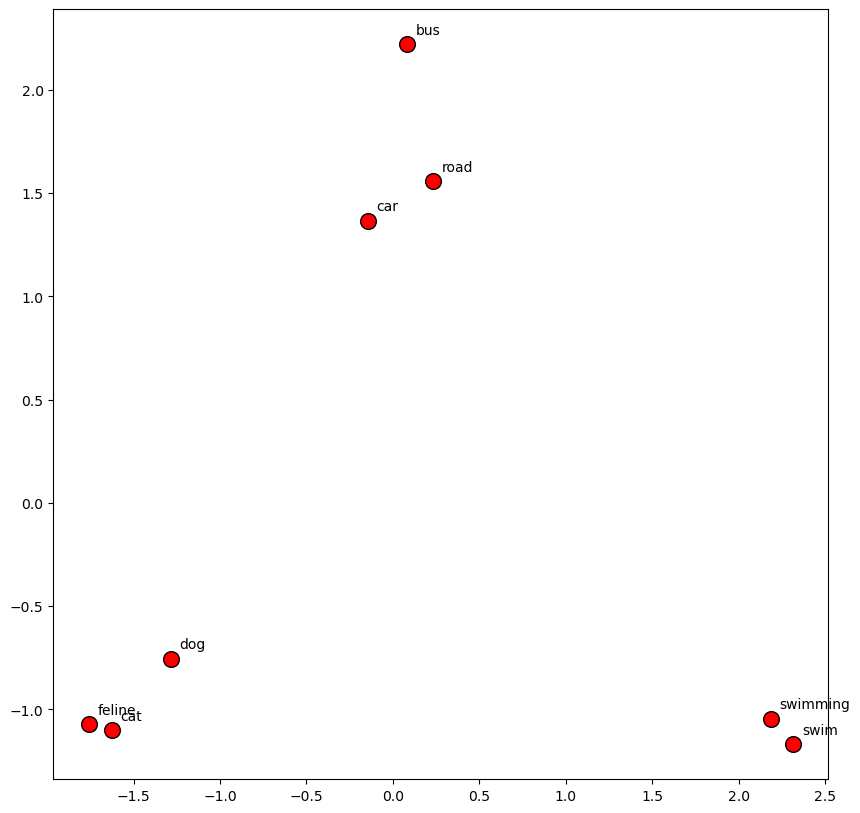

In [24]:
display_pca_scatterplot(word_vectors, ['swim', 'swimming', 'cat', 'dog', 'feline', 'road', 'car', 'bus'])


In [25]:
word_vectors.most_similar(positive=['Italy', 'London'], negative=['Rome'], topn=3)


[('UK', 0.623056948184967),
 ('Britain', 0.6016389727592468),
 ('United_Kingdom', 0.5343458652496338)]

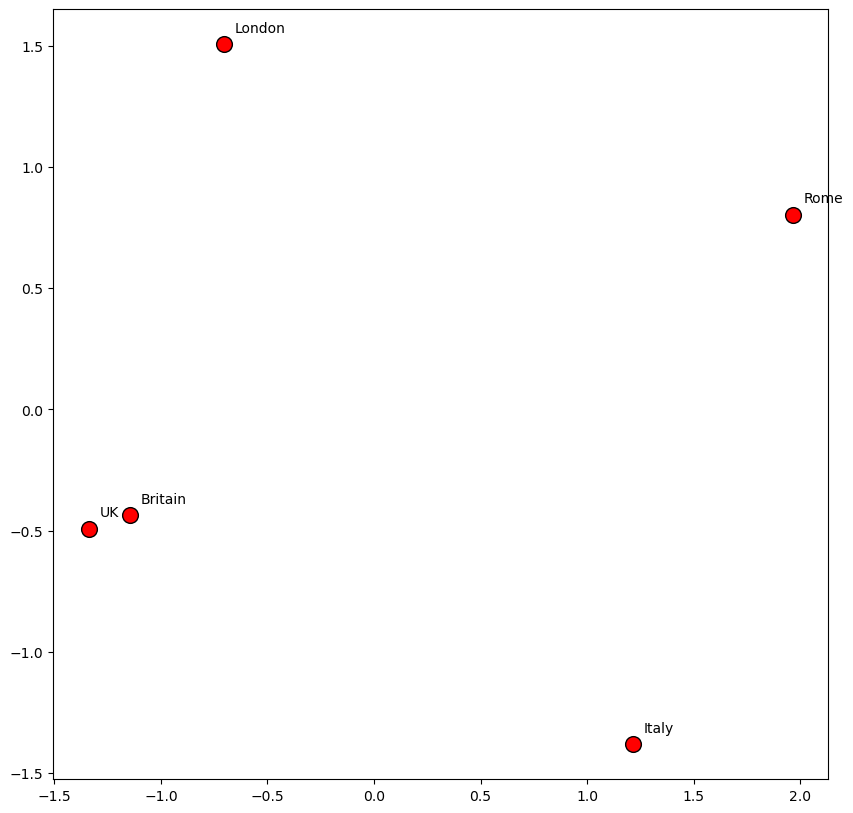

In [26]:
display_pca_scatterplot(word_vectors, ['Rome', 'Italy', 'London', 'Britain', 'UK'])


## 3 Using Pretrained Word Vectors for Classification


In [27]:
word_vectors = KeyedVectors.load_word2vec_format(output, binary=True) # limit=None

print(len(word_vectors))


3000000


### using a validation set


In [28]:
train_df, val_df = train_test_split(train_df, train_size=0.9, random_state=1)

train_df.reset_index(drop=True, inplace=True)
val_df.reset_index(drop=True, inplace=True)

display(train_df.head())


,CreationDate,title,body,all_tags,title_nltk,body_nltk,title_spacy,body_spacy,top_tags_30
0,2013-09-29 12:44:22,Python: How would you save a simple settings/c...,"I don't care if it's JSON, pickle, YAML, or wh...","[python, json, settings, config, ini]","[python, save, setting, config, file]","[python, save, setting, config, file, care, js...","[save, setting, file]","[care, json, pickle, implementation, config, f...","[python, json]"
1,2012-08-03 07:42:28,"My Routes are Returning a 404, How can I Fix T...",I've just started learning the Laravel framewo...,"[php, laravel, routes, laravel-routing, larave...","[route, return, fix]","[route, return, fix, start, learn, laravel, fr...","[return, fix]","[start, learn, framework, issue, routing, rout...",[php]
2,2013-03-06 00:24:26,Should I use MapView or MapFragment,I am not sure whether I should be using MapVie...,"[android, google-maps, android-mapview, google...","[mapview, mapfragment]","[mapview, mapfragment, mapview, stick, mapfrag...",[use],"[stick, application, app, find, set, place, wa...",[android]
3,2012-06-14 11:17:52,bootstrap scrollspy highlights last navigation...,I've built a navigation bar at the top with 5 ...,"[javascript, jquery, css, twitter-bootstrap, t...","[bootstrap, highlight, navigation, link, butto...","[bootstrap, highlight, navigation, link, butto...","[link, button, load]","[build, navigation, bar, link, page, add, sect...","[javascript, jquery, css]"
4,2018-10-12 02:23:10,How to insert a record with custom id use Spri...,"For Spring Data JPA, I can use @GeneratedValue...","[java, spring, insert, id-generation, spring-d...","[insert, record, custom, id, spring, data, jdbc]","[insert, record, custom, id, spring, data, jdb...","[insert, record, custom, use, data, jdbc]","[use, insert, record, custom, insert, record, ...","[java, spring]"


In [29]:
# Set up training data.

feature = 'title' # on va testeer le tokenizer de keras
target = 'top_tags_' + str(NB_TAGS)

X_train = train_df[feature].values
y_train = train_df[target].tolist()

# Set up validation data.
X_val = val_df[feature].values
y_val = val_df[target].tolist()


In [30]:
# encodage target

def target_encoding(y):
    # Target encoding
    mlb = MultiLabelBinarizer()
    y_encoded = mlb.fit_transform(y)

    return y_encoded


y_train_encoded = target_encoding(y_train)
y_val_encoded = target_encoding(y_val)

print(y_train_encoded)


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 1 0 1]
 [0 0 0 ... 0 0 0]]


In [31]:
tokenizer = keras.preprocessing.text.Tokenizer(num_words=20000,
                                               filters='0123456789!"#$%&()*+,-./:;<=>?@[\]^_`{|}~',
                                               lower=True)

tokenizer.fit_on_texts(X_train)


In [32]:
X_train_tokens = tokenizer.texts_to_sequences(X_train)

print(X_train_tokens[0])
print([tokenizer.index_word[x] for x in X_train_tokens[0][:3]])


[19, 3, 947, 161, 299, 4, 383, 696, 411, 18]
['python', 'how', 'would']


In [33]:
# Review excerpt reconstructed from integer sequence.
tokenizer.sequences_to_texts([X_train_tokens[0]])[0][:300]


'python how would you save a simple settings config file'

In [34]:
# Original review text.
train_df[feature].iloc[0][:300]


'Python: How would you save a simple settings/config file?'

In [35]:
# Get the number of tokens for each text
num_tokens = [len(tokens) for tokens in tokenizer.texts_to_sequences(X_train)]

# Calculate statistics
mean_tokens = np.mean(num_tokens)
median_tokens = np.median(num_tokens)
mode_tokens = max(set(num_tokens), key=num_tokens.count)
std_tokens = np.std(num_tokens)

# Print statistics
print("Mean number of tokens:", mean_tokens)
print("Median number of tokens:", median_tokens)
print("Mode number of tokens:", mode_tokens)
print("Standard deviation of tokens:", std_tokens)


Mean number of tokens: 9.256941566514712
Median number of tokens: 9.0
Mode number of tokens: 8
Standard deviation of tokens: 3.527257324144907


In [36]:
# Convert list to DataFrame
df_num_tokens = pd.DataFrame(num_tokens, columns=['num_tokens'])

# Use describe() to get summary statistics
summary_stats = df_num_tokens.describe()

print(summary_stats)


         num_tokens
count  19304.000000
mean       9.256942
std        3.527349
min        2.000000
25%        7.000000
50%        9.000000
75%       11.000000
max       29.000000


In [37]:
summary_stats = df_num_tokens.loc[df_num_tokens['num_tokens'] > 11, :].describe()

print(summary_stats)

# OK on va prendre jusqu'à 15 inclus


        num_tokens
count  4377.000000
mean     14.336303
std       2.611891
min      12.000000
25%      12.000000
50%      14.000000
75%      15.000000
max      29.000000


### Padding


In [38]:
# Pas indispensable ici, mais bientôt utile

MAX_LEN = 15
X_train = keras.preprocessing.sequence.pad_sequences(X_train_tokens, maxlen=MAX_LEN)


In [39]:
print(X_train[0])
print(X_train[1])


[  0   0   0   0   0  19   3 947 161 299   4 383 696 411  18]
[   0    0    0    0    0   97 1268   70  555    4    3   23   15  341
  948]


In [40]:
X_val = tokenizer.texts_to_sequences(X_val)
X_val = keras.preprocessing.sequence.pad_sequences(X_val, maxlen=MAX_LEN)


In [41]:
# + 1 to account for padding token.
num_tokens = len(tokenizer.word_index) + 1
print(num_tokens)

# Initialize a matrix of zeroes of size: vocabulary x embedding dimension.
embedding_dim = 300
embedding_matrix = np.zeros((num_tokens, embedding_dim))

for word, i in tokenizer.word_index.items():
  if word_vectors.has_index_for(word):
    embedding_matrix[i] = word_vectors[word].copy()


12641


In [42]:
# Quick visual check.
print(embedding_matrix[tokenizer.word_index['good']][:50])


[ 0.04052734  0.0625     -0.01745605  0.07861328  0.03271484 -0.01263428
  0.00964355  0.12353516 -0.02148438  0.15234375 -0.05834961 -0.10644531
  0.02124023  0.13574219 -0.13183594  0.17675781  0.27148438  0.13769531
 -0.17382812 -0.14160156 -0.03076172  0.19628906 -0.03295898  0.125
  0.25390625  0.12695312 -0.15234375  0.03198242  0.01135254 -0.01361084
 -0.12890625  0.01019287  0.23925781 -0.08447266  0.140625    0.13085938
 -0.04516602  0.06494141  0.02539062  0.05615234  0.24609375 -0.20507812
  0.23632812 -0.00860596 -0.02294922  0.05078125  0.10644531 -0.03564453
  0.08740234 -0.05712891]


In [43]:
embedding_layer = layers.Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    input_length=MAX_LEN,
    trainable=True
)


In [44]:
tf.random.set_seed(0)

model = keras.Sequential()

# This layer will output a sequence of 300-dimension *vectors*, one for each element in the input sequence.
model.add(embedding_layer)

# This layer will calculate an average of those vectors.
model.add(layers.GlobalAveragePooling1D())

model.add(layers.Dense(150, activation='relu', kernel_initializer=tf.keras.initializers.random_normal(seed=1)))
model.add(layers.Dense(75, activation='relu', kernel_initializer=tf.keras.initializers.random_normal(seed=1)))
model.add(layers.Dense(NB_TAGS, activation='sigmoid', kernel_initializer=tf.keras.initializers.random_normal(seed=1)))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


2024-02-12 15:00:37.369593: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [45]:
# modif

review = "fantastic papaya steak"
print(f"Review: {review}")

review_sequence = tokenizer.texts_to_sequences([review])
print(f"Review as sequence of integers: {review_sequence}")

review_embeddings = embedding_layer(np.array(review_sequence))
print(f"Review embeddings shape: (Batch size: {review_embeddings.shape[0]}, \
Sequence length: {review_embeddings.shape[1]}, \
Embedding size: {review_embeddings.shape[2]})")

# How our document will be presented to the rest of the neural network.
print(f"Average of embeddings (shape): {np.mean(review_embeddings, axis=1).shape}")


Review: fantastic papaya steak
Review as sequence of integers: [[]]
Review embeddings shape: (Batch size: 1, Sequence length: 0, Embedding size: 300)
Average of embeddings (shape): (1, 300)


/home/ubuntu/anaconda3/envs/myenv_p5/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ubuntu/anaconda3/envs/myenv_p5/lib/python3.11/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


In [46]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 15, 300)           3792300   
                                                                 
 global_average_pooling1d (G  (None, 300)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 150)               45150     
                                                                 
 dense_1 (Dense)             (None, 75)                11325     
                                                                 
 dense_2 (Dense)             (None, 30)                2280      
                                                                 
Total params: 3,851,055
Trainable params: 3,851,055
Non-trainable params: 0
______________________________________________

In [47]:
history = model.fit(X_train, y_train_encoded, epochs=20, batch_size=512, validation_data=(X_val, y_val_encoded))


Epoch 1/20


38/38 [==============================] - 7s 150ms/step - loss: 0.4730 - accuracy: 0.0298 - val_loss: 0.2008 - val_accuracy: 0.0466
Epoch 2/20
38/38 [==============================] - 4s 111ms/step - loss: 0.1788 - accuracy: 0.0887 - val_loss: 0.1698 - val_accuracy: 0.0956
Epoch 3/20
38/38 [==============================] - 5s 127ms/step - loss: 0.1681 - accuracy: 0.0965 - val_loss: 0.1674 - val_accuracy: 0.0956
Epoch 4/20
38/38 [==============================] - 5s 124ms/step - loss: 0.1661 - accuracy: 0.0976 - val_loss: 0.1660 - val_accuracy: 0.0956
Epoch 5/20
38/38 [==============================] - 5s 131ms/step - loss: 0.1648 - accuracy: 0.0974 - val_loss: 0.1653 - val_accuracy: 0.0956
Epoch 6/20
38/38 [==============================] - 5s 121ms/step - loss: 0.1639 - accuracy: 0.1054 - val_loss: 0.1648 - val_accuracy: 0.0956
Epoch 7/20
38/38 [==============================] - 5s 121ms/step - loss: 0.1630 - accuracy: 0.1113 - val_loss: 0.1643 - val_accuracy: 0.0998
Epoch 8/20
38/38 

In [48]:
def plot_train_vs_val_performance(history):
  training_losses = history.history['loss']
  validation_losses = history.history['val_loss']

  training_accuracy = history.history['accuracy']
  validation_accuracy = history.history['val_accuracy']

  epochs = range(1, len(training_losses) + 1)

  import matplotlib.pyplot as plt
  fig, (ax1, ax2) = plt.subplots(2)
  fig.set_figheight(15)
  fig.set_figwidth(15)
  fig.tight_layout(pad=5.0)

  # Plot training vs. validation loss.
  ax1.plot(epochs, training_losses, 'bo', label='Training Loss')
  ax1.plot(epochs, validation_losses, 'b', label='Validation Loss')
  ax1.title.set_text('Training vs. Validation Loss')
  ax1.set_xlabel('Epoch')
  ax1.set_ylabel('Loss')
  ax1.legend()

  # PLot training vs. validation accuracy.
  ax2.plot(epochs, training_accuracy, 'bo', label='Training Accuracy')
  ax2.plot(epochs, validation_accuracy, 'b', label='Validation Accuracy')
  ax2.title.set_text('Training vs. Validation Accuracy')
  ax2.set_xlabel('Epoch')
  ax2.set_ylabel('Accuracy')
  ax2.legend()

  plt.show()

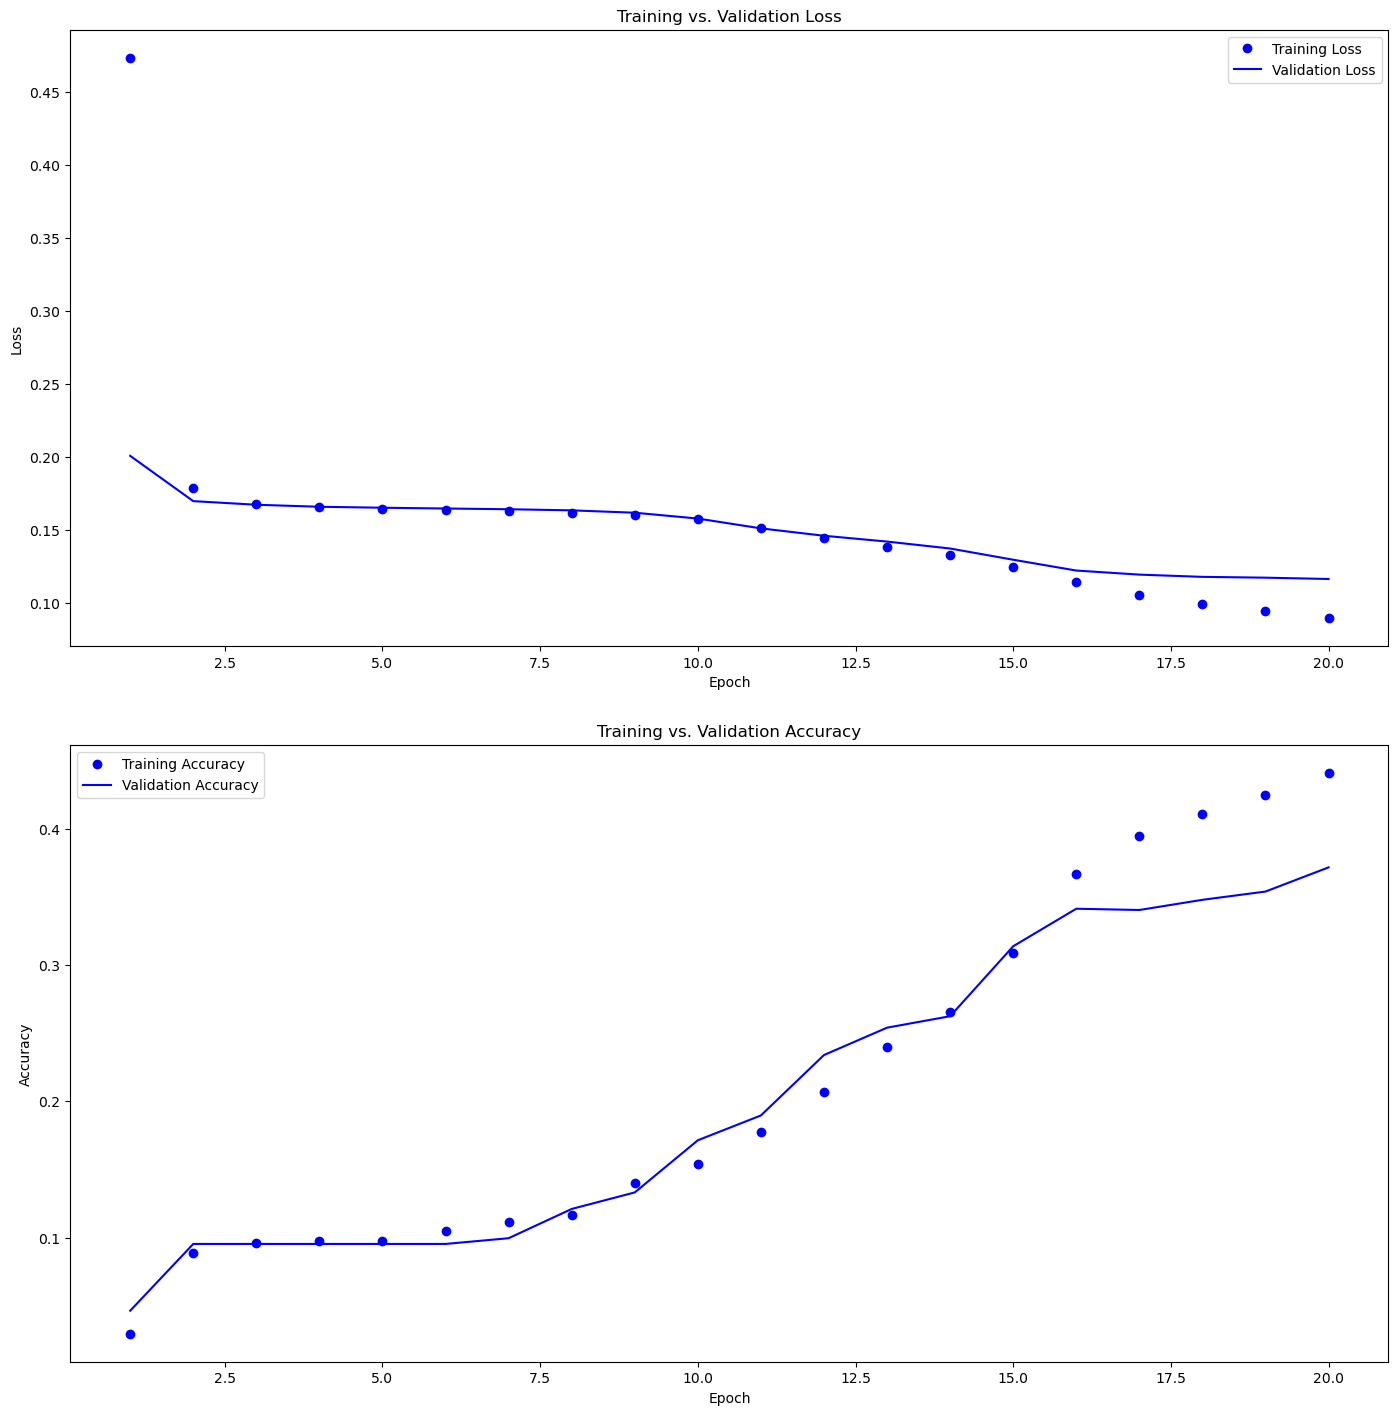

In [49]:
plot_train_vs_val_performance(history)


In [68]:
# overfitting apres 16 iterations (epochs)

embedding_layer = layers.Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    input_length=MAX_LEN,
    trainable=True,
    mask_zero=True
)

model = keras.Sequential()

model.add(embedding_layer)

model.add(layers.GlobalAveragePooling1D())

model.add(layers.Dense(150, activation='relu', kernel_initializer=tf.keras.initializers.random_normal(seed=1)))
model.add(layers.Dense(75, activation='relu', kernel_initializer=tf.keras.initializers.random_normal(seed=1)))
model.add(layers.Dense(NB_TAGS, activation='sigmoid', kernel_initializer=tf.keras.initializers.random_normal(seed=1)))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


model.fit(X_train, y_train_encoded, epochs=16, batch_size=512, validation_data=(X_val, y_val_encoded))


Epoch 1/16
38/38 [==============================] - 5s 119ms/step - loss: 0.4512 - accuracy: 0.0305 - val_loss: 0.2043 - val_accuracy: 0.0858
Epoch 2/16
38/38 [==============================] - 4s 97ms/step - loss: 0.1780 - accuracy: 0.0937 - val_loss: 0.1700 - val_accuracy: 0.1068
Epoch 3/16
38/38 [==============================] - 4s 100ms/step - loss: 0.1678 - accuracy: 0.1005 - val_loss: 0.1671 - val_accuracy: 0.0956
Epoch 4/16
38/38 [==============================] - 4s 98ms/step - loss: 0.1653 - accuracy: 0.1026 - val_loss: 0.1656 - val_accuracy: 0.1049
Epoch 5/16
38/38 [==============================] - 4s 96ms/step - loss: 0.1635 - accuracy: 0.1153 - val_loss: 0.1645 - val_accuracy: 0.1110
Epoch 6/16
38/38 [==============================] - 4s 100ms/step - loss: 0.1613 - accuracy: 0.1321 - val_loss: 0.1619 - val_accuracy: 0.1394
Epoch 7/16
38/38 [==============================] - 4s 94ms/step - loss: 0.1569 - accuracy: 0.1630 - val_loss: 0.1564 - val_accuracy: 0.1781
Epoch 8/16

In [69]:
X_test = test_df[feature].values
y_test = test_df[target].tolist()

y_test_encoded = target_encoding(y_test)

X_test = tokenizer.texts_to_sequences(X_test)
X_test = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=MAX_LEN)

model.evaluate(X_test, y_test_encoded)


75/75 [==============================] - 0s 3ms/step - loss: 0.1094 - accuracy: 0.3977


[0.1093788892030716, 0.3976510167121887]

In [74]:
def predict_tags(text, tokenizer=tokenizer, maxlen=MAX_LEN):
    seqs = tokenizer.texts_to_sequences([text])
    print(len(seqs))
    print(seqs)
    for seq in seqs:
        print(seq)
        print([tokenizer.index_word[x] for x in seq])

    seqs = keras.preprocessing.sequence.pad_sequences(seqs, maxlen=maxlen)

    return model.predict(seqs)


tags = predict_tags(text="The best the best sea food apple pie")


1
[[5, 255, 5, 255, 810, 2228]]
[5, 255, 5, 255, 810, 2228]
['the', 'best', 'the', 'best', 'apple', 'pie']
1/1 [==============================] - 0s 13ms/step


In [64]:
pprint(tags)
print(tags.shape)


array([[0.06758902, 0.02515453, 0.02944748, 0.04119842, 0.03074838,
        0.02852686, 0.14833239, 0.0575094 , 0.02864316, 0.05619066,
        0.02806263, 0.01281984, 0.04966058, 0.1472763 , 0.03734109,
        0.04452341, 0.03297187, 0.02417095, 0.06163792, 0.01727027,
        0.00172404, 0.07239021, 0.0119509 , 0.00656581, 0.0377373 ,
        0.00805124, 0.034202  , 0.01463107, 0.03870042, 0.0163191 ]],
      dtype=float32)
(1, 30)


In [67]:
# OK reste juste à récup / associer les tags equivalents (targets)


# Step 1: Make predictions with the model
predictions = model.predict(X_test[:25])

# Step 2: Get the indices of the top n most probable tags
n = 5  # Number of top tags to return
top_n_indices = np.argsort(predictions, axis=1)[:, -n:]

# Step 3: Get the associated tags
associated_tags = []
for indices in top_n_indices:
    tags = [all_tags[i] for i in indices]
    associated_tags.append(tags)

# Print associated tags for each input text
for i, tags in enumerate(associated_tags):
    print(f"Top {n} tags for input text {i + 1}: {', '.join(tags)}")



1/1 [==============================] - 0s 18ms/step


Top 5 tags for input text 1: amazon-web-services, python, upgrade, langchain, compiler-errors
Top 5 tags for input text 2: spring-boot, langchain, python, upgrade, compiler-errors
Top 5 tags for input text 3: google-chrome, selenium-webdriver, langchain, chatbot, flask
Top 5 tags for input text 4: google-chrome, selenium-webdriver, openai-api, flask, chatbot
Top 5 tags for input text 5: java-21, python, spring-boot, compiler-errors, large-language-model
Top 5 tags for input text 6: python, spring-security, upgrade, compiler-errors, eclipse
Top 5 tags for input text 7: chatbot, compiler-errors, llama-index, java-21, large-language-model
Top 5 tags for input text 8: python, spring-security, upgrade, compiler-errors, eclipse
Top 5 tags for input text 9: python, selenium-webdriver, langchain, chatbot, flask
Top 5 tags for input text 10: flask, java-21, chatbot, compiler-errors, large-language-model
Top 5 tags for input text 11: spring-boot, python, flask, compiler-errors, langchain
Top 5 t

## 4 BERT


## Ressources


In [ ]:
# Word
# https://colab.research.google.com/github/futuremojo/nlp-demystified/blob/main/notebooks/nlpdemystified_word_vectors.ipynb#scrollTo=SBQlbyiVY3WJ